# Ingestion

In [1]:
%run ingestion.ipynb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   facility      810 non-null    object 
 1   date          481 non-null    object 
 2   timeStart     810 non-null    object 
 3   timeEnd       481 non-null    object 
 4   supplierCode  481 non-null    object 
 5   suppliedM3    810 non-null    float64
 6   recoveredM3   810 non-null    float64
 7   processTime   329 non-null    object 
 8   supplier      329 non-null    object 
dtypes: float64(2), object(7)
memory usage: 57.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   facility_code    810 non-null    int64         
 1   supplier_code    810 non-null    int64         
 2   start_date_time  810 non-null    datetime64[ns]
 

In [2]:
df

,facility_code,supplier_code,start_date_time,process_time,input,output,throughput,recovery_rate
0,0,4,2022-08-01 08:29:00,2280.0,2.00,1.55,0.040789,0.775000
1,0,5,2022-08-01 09:27:00,7260.0,6.80,4.15,0.034298,0.610294
2,0,4,2022-08-01 11:38:00,2580.0,1.95,1.55,0.036047,0.794872
3,0,6,2022-08-01 12:40:00,5040.0,3.95,2.55,0.030357,0.645570
4,0,5,2022-08-01 14:25:00,7440.0,5.30,3.10,0.025000,0.584906
...,...,...,...,...,...,...,...,...
805,0,6,2022-09-30 11:40:00,3660.0,3.70,2.35,0.038525,0.635135
806,0,5,2022-09-30 12:52:00,6240.0,6.35,4.55,0.043750,0.716535
807,1,0,2022-09-30 13:48:00,220.0,4.53,2.73,0.744545,0.602649
808,0,4,2022-09-30 15:02:00,2400.0,2.00,1.45,0.036250,0.725000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   facility_code    810 non-null    int64         
 1   supplier_code    810 non-null    int64         
 2   start_date_time  810 non-null    datetime64[ns]
 3   process_time     810 non-null    float32       
 4   input            810 non-null    float32       
 5   output           810 non-null    float32       
 6   throughput       810 non-null    float32       
 7   recovery_rate    810 non-null    float32       
dtypes: datetime64[ns](1), float32(5), int64(2)
memory usage: 34.9 KB


---
# Setup

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import (
    scatter_matrix
)

---
# Analysis

## Histgram per column

array([[<AxesSubplot: title={'center': 'facility_code'}>,
        <AxesSubplot: title={'center': 'supplier_code'}>,
        <AxesSubplot: title={'center': 'start_date_time'}>],
       [<AxesSubplot: title={'center': 'process_time'}>,
        <AxesSubplot: title={'center': 'input'}>,
        <AxesSubplot: title={'center': 'output'}>],
       [<AxesSubplot: title={'center': 'throughput'}>,
        <AxesSubplot: title={'center': 'recovery_rate'}>,
        <AxesSubplot: >]], dtype=object)

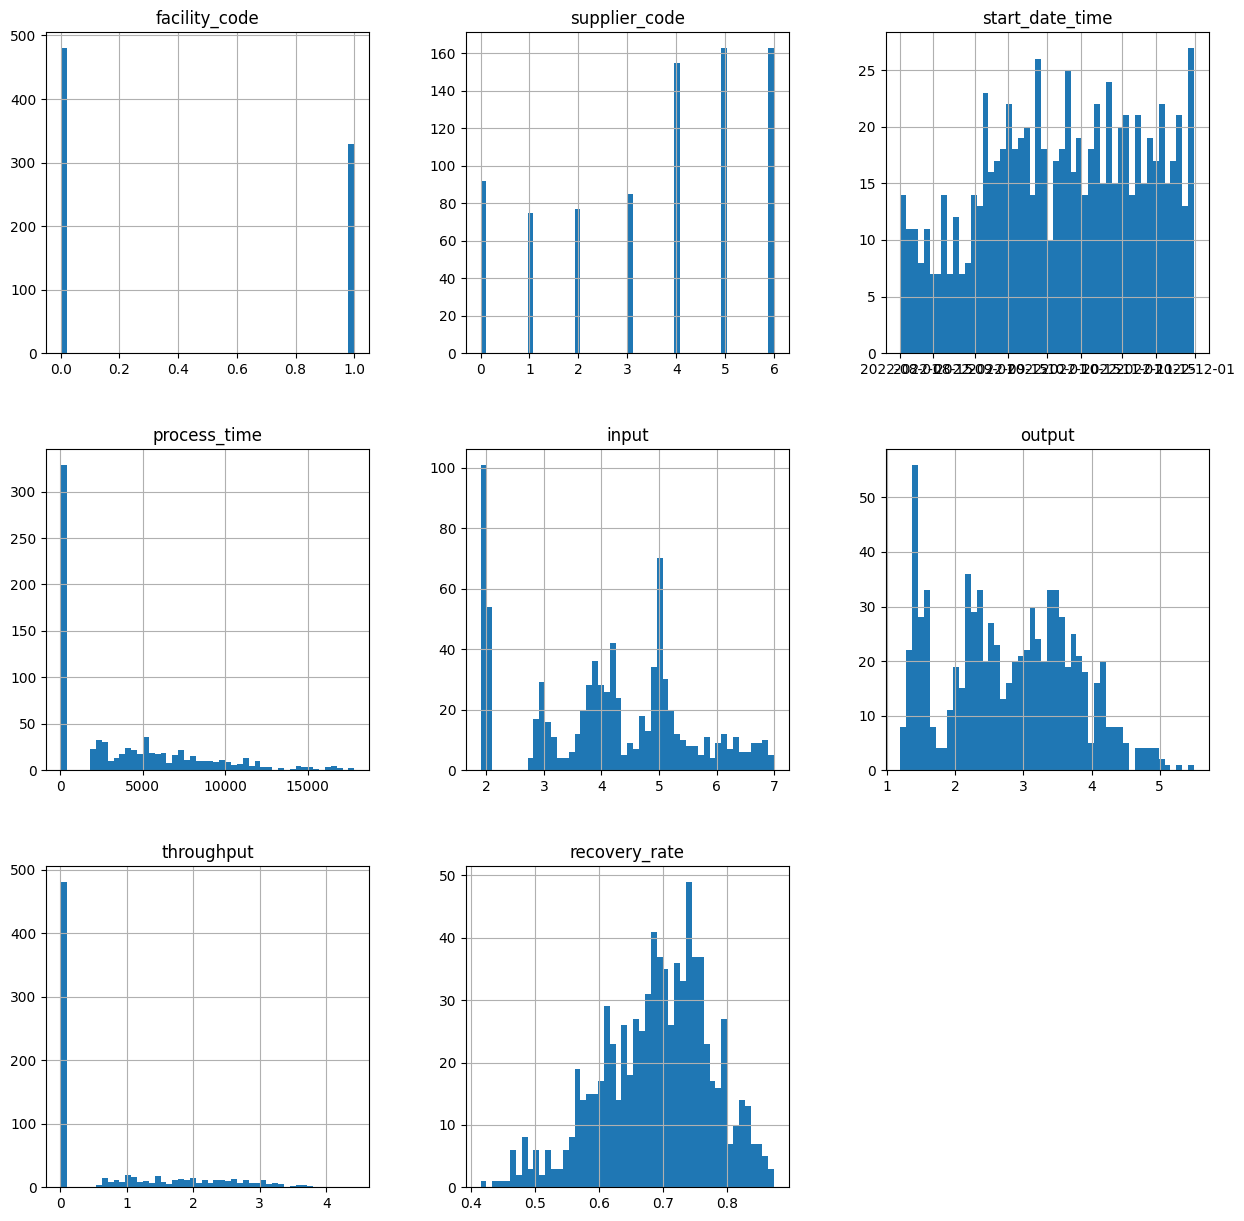

In [5]:
df.hist(bins=50, figsize=(15, 15))

## Correlations

In [6]:
correlations = df.corr()

/var/folders/_4/8v285hqs45xfzk0l1nlr3yq40000gn/T/ipykernel_83327/446670884.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()


In [7]:
for column_name in df.columns:
    if column_name not in [
        COLUMN_START_TIME, 
        COLUMN_END_TIME,
    ]:
        # print("-" * 80, end='')
        display(correlations[column_name].sort_values(ascending=False))

facility_code    1.000000
throughput       0.866242
recovery_rate    0.234719
output           0.176723
input            0.075345
process_time    -0.754958
supplier_code   -0.874723
Name: facility_code, dtype: float64

supplier_code    1.000000
process_time     0.739652
input            0.096203
output          -0.003644
recovery_rate   -0.261907
throughput      -0.751520
facility_code   -0.874723
Name: supplier_code, dtype: float64

process_time     1.000000
supplier_code    0.739652
input            0.390651
output           0.262841
recovery_rate   -0.341238
throughput      -0.661105
facility_code   -0.754958
Name: process_time, dtype: float64

input            1.000000
output           0.930298
process_time     0.390651
supplier_code    0.096203
facility_code    0.075345
throughput       0.039027
recovery_rate   -0.275432
Name: input, dtype: float64

output           1.000000
input            0.930298
process_time     0.262841
facility_code    0.176723
throughput       0.149140
recovery_rate    0.084698
supplier_code   -0.003644
Name: output, dtype: float64

throughput       1.000000
facility_code    0.866242
recovery_rate    0.265277
output           0.149140
input            0.039027
process_time    -0.661105
supplier_code   -0.751520
Name: throughput, dtype: float64

recovery_rate    1.000000
throughput       0.265277
facility_code    0.234719
output           0.084698
supplier_code   -0.261907
input           -0.275432
process_time    -0.341238
Name: recovery_rate, dtype: float64

In [8]:
attributes = [
    COLUMN_FACILITY_CODE,
    COLUMN_SUPPLIER_CODE,
    COLUMN_START_TIME, 
    COLUMN_PROCESS_TIME,
    COLUMN_INPUT,
    COLUMN_OUTPUT,
    COLUMN_THROUGHPUT,
    COLUMN_RECOVERY_RATE,
]    

array([[<AxesSubplot: xlabel='facility_code', ylabel='facility_code'>,
        <AxesSubplot: xlabel='supplier_code', ylabel='facility_code'>,
        <AxesSubplot: xlabel='process_time', ylabel='facility_code'>,
        <AxesSubplot: xlabel='input', ylabel='facility_code'>,
        <AxesSubplot: xlabel='output', ylabel='facility_code'>,
        <AxesSubplot: xlabel='throughput', ylabel='facility_code'>,
        <AxesSubplot: xlabel='recovery_rate', ylabel='facility_code'>],
       [<AxesSubplot: xlabel='facility_code', ylabel='supplier_code'>,
        <AxesSubplot: xlabel='supplier_code', ylabel='supplier_code'>,
        <AxesSubplot: xlabel='process_time', ylabel='supplier_code'>,
        <AxesSubplot: xlabel='input', ylabel='supplier_code'>,
        <AxesSubplot: xlabel='output', ylabel='supplier_code'>,
        <AxesSubplot: xlabel='throughput', ylabel='supplier_code'>,
        <AxesSubplot: xlabel='recovery_rate', ylabel='supplier_code'>],
       [<AxesSubplot: xlabel='facility_cod

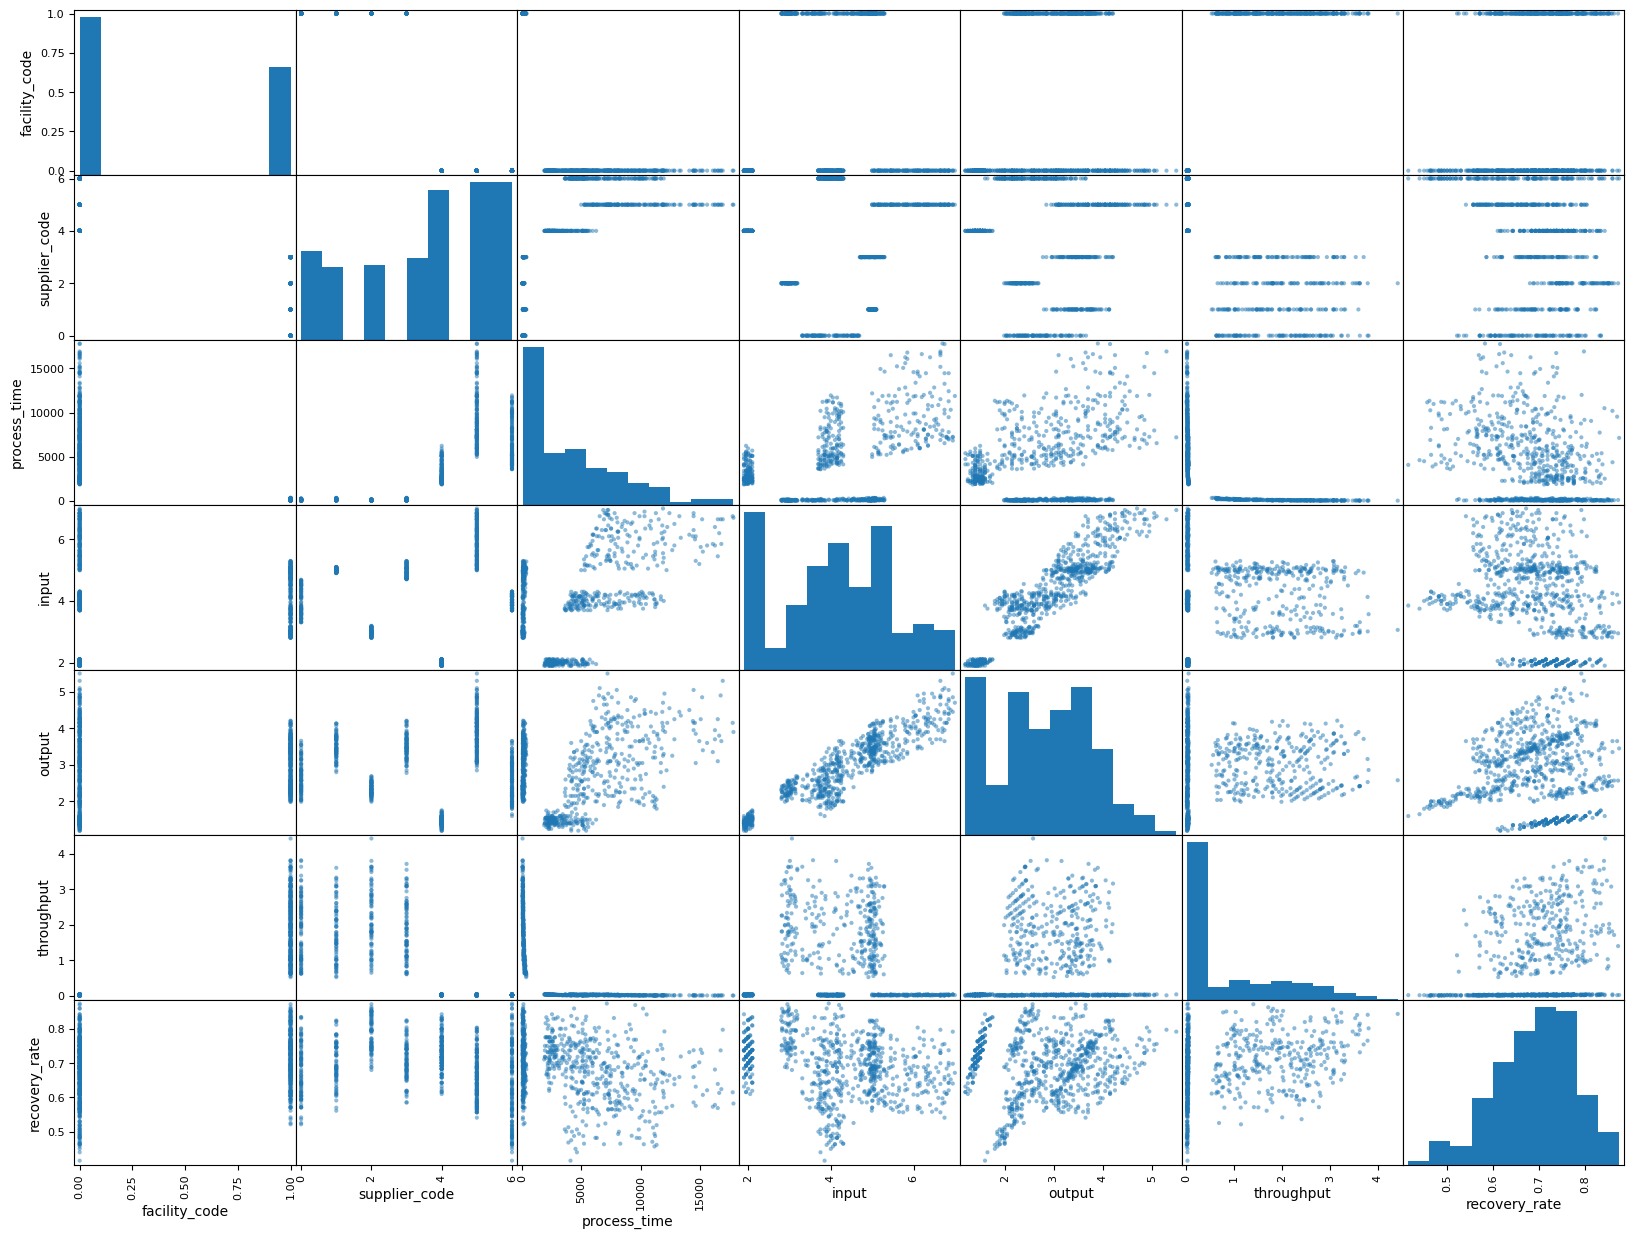

In [9]:
scatter_matrix(df[attributes], figsize=(20, 15))

---
# Performance


## Recovery Per Facility

Bundaberg/1 has higher (6%) recovery rate.

In [10]:
df.groupby(COLUMN_FACILITY_CODE)[COLUMN_RECOVERY_RATE].mean()

facility_code
0    0.673939
1    0.714824
Name: recovery_rate, dtype: float32

## Throughput per Facility

Bundaberg/1 has far better throughput.

In [11]:
df.groupby(COLUMN_FACILITY_CODE)[COLUMN_THROUGHPUT].mean()

facility_code
0    0.027834
1    1.933562
Name: throughput, dtype: float32

In [14]:
df.groupby([COLUMN_FACILITY_CODE])[COLUMN_PROCESS_TIME].mean()

facility_code
0    6508.814941
1     118.085106
Name: process_time, dtype: float32


### Per Facility/Supplier

All the Mary X use Bundaberg facility with higher performances.

In [13]:
df.groupby([COLUMN_FACILITY_CODE, COLUMN_SUPPLIER_CODE])[COLUMN_THROUGHPUT].mean()

facility_code  supplier_code
0              4                0.030302
               5                0.027365
               6                0.025957
1              0                1.896206
               1                1.810008
               2                2.158897
               3                1.878886
Name: throughput, dtype: float32